In [65]:
import pandas as pd
import numpy as np
import seaborn as sns
bicon = pd.read_csv('datasets/bioCON_plant_diversity.txt', delimiter='\t')

# Data sampling and collection

# Data cleaning

In [66]:
bicon

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
0,2002,1,1,Cenrich,Namb,4,2,M,,,,,0-10,0.618,0.074,8.351351351
1,2002,1,1,Cenrich,Namb,4,2,M,,,,,10-20,0.515,0.057,9.035087719
2,2002,1,1,Cenrich,Namb,4,2,M,,,,,20-40,0.142,0.023,6.173913043
3,2002,1,1,Cenrich,Namb,4,2,M,,,,,40-60,0.132,0.016,8.25
4,2002,2,1,Cenrich,Namb,1,1,M,Bouteloua gracilis,C-4,,,0-10,0.55,0.07,7.857142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5628,2016,365,6,Camb,Nenrich,4,2,M,,,,,40-60,0.329,0.027,12.18518519
5629,2016,366,6,Camb,Nenrich,1,1,M,Achillea millefolium,Forb,,,0-10,0.85,0.066,12.87878788
5630,2016,366,6,Camb,Nenrich,1,1,M,Achillea millefolium,Forb,,,10-20,0.57,0.05,11.4
5631,2016,366,6,Camb,Nenrich,1,1,M,Achillea millefolium,Forb,,,20-40,0.454,0.036,12.61111111


In [67]:
bicon['monospecies'].unique()

array([' ', 'Bouteloua gracilis', 'Asclepias tuberosa',
       'Schizachyrium scoparium', 'Amorpha canescens', 'Bromus inermis',
       'Agropyron repens', 'Lespedeza capitata', 'Petalostemum villosum',
       'Poa pratensis', 'Solidago rigida', 'Anemone cylindrica',
       'Koeleria cristata', 'Achillea millefolium', 'Lupinus perennis',
       'Andropogon gerardi', 'Sorghastrum nutans'], dtype=object)

In [68]:
bicon['Carbon(%)'].replace('', np.nan, inplace=True)
bicon['Nitrogen(%)'].replace('', np.nan, inplace=True)
bicon['C/N Ratio'].replace(' ', np.nan, inplace=True)
bicon.dropna(subset=['Carbon(%)', 'Nitrogen(%)', 'C/N Ratio'], inplace=True)
bicon['Carbon(%)'] = bicon['Carbon(%)'].astype(float)
bicon['Nitrogen(%)'] = bicon['Nitrogen(%)'].astype(float)
bicon['C/N Ratio'] = bicon['C/N Ratio'].astype(float)

# Exploratory data analysis

<AxesSubplot: xlabel='CountOfSpecies'>

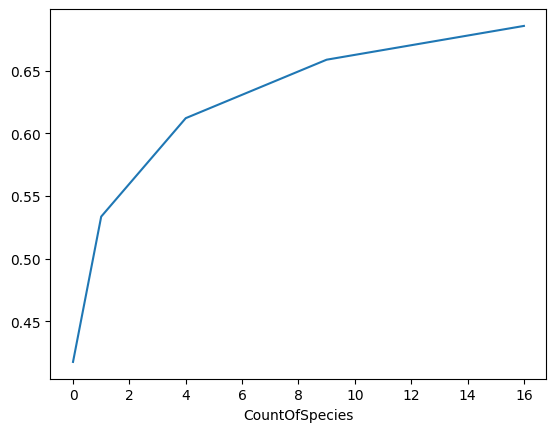

In [69]:
bicon.groupby(['CountOfSpecies'])['Carbon(%)'].mean().plot()

<AxesSubplot: xlabel='CountOfSpecies'>

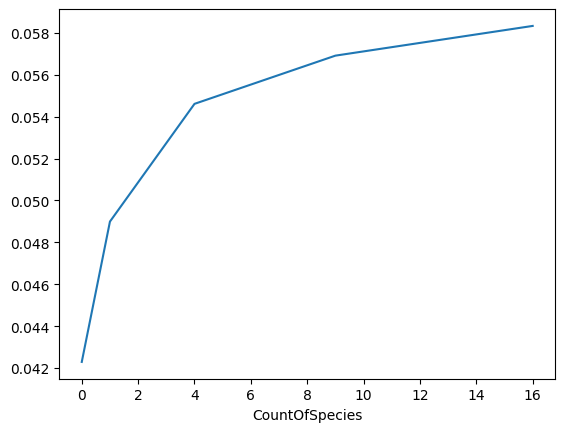

In [70]:
bicon.groupby(['CountOfSpecies'])['Nitrogen(%)'].mean().plot()

In [71]:
bicon[(bicon['Temp Treatment'] == 'HTelv') | (bicon['Temp Treatment'] == 'HTamb')]['Carbon(%)'].mean()

0.6662741514360313

In [72]:
bicon.groupby('Year').mean()

/var/folders/rp/0n508lmj72ldc75gvssc3p200000gn/T/ipykernel_1361/3005142552.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bicon.groupby('Year').mean()


,Plot,CountOfSpecies,CountOfGroup,Carbon(%),Nitrogen(%),C/N Ratio
Year,,,,,,
2002,186.111336,5.192308,2.269231,0.555184,0.056675,9.873872
2007,186.000000,5.196765,2.269542,0.644554,0.056111,11.191059
2012,185.896831,5.199595,2.270398,0.619814,0.054675,11.216634
2016,183.597956,5.695060,2.469336,0.559779,0.043070,13.676147


<AxesSubplot: xlabel='Nitrogen Treatment', ylabel='Nitrogen(%)'>

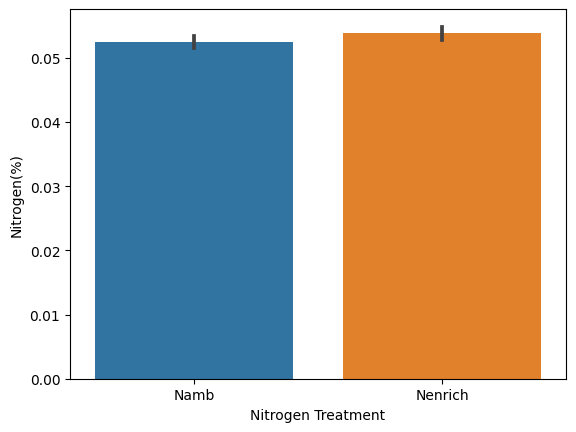

In [73]:
#sns.lmplot(x = "Nitrogen(%)", y = "Carbon(%)", data = bicon, hue = "Nitrogen Treatment", scatter_kws={"s": 1})
sns.barplot(data = bicon, x="Nitrogen Treatment", y='Nitrogen(%)' )

<AxesSubplot: xlabel='CO2 Treatment', ylabel='Carbon(%)'>

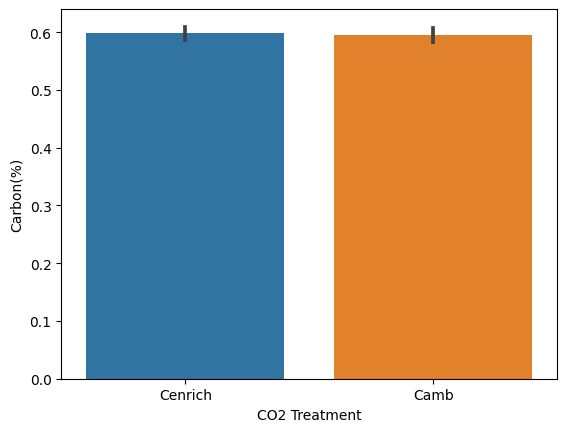

In [74]:
sns.barplot(data = bicon, x="CO2 Treatment", y='Carbon(%)' )

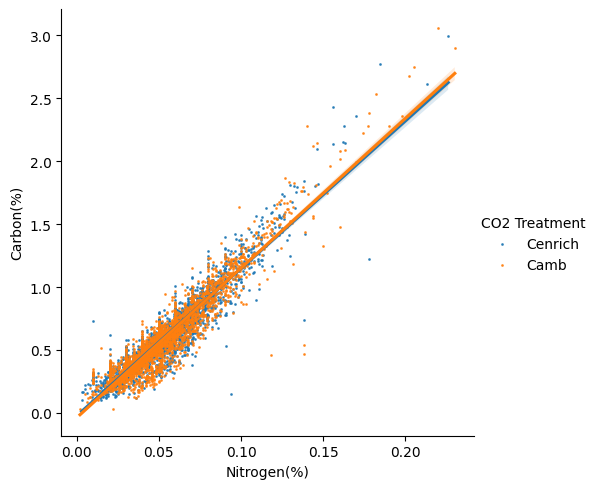

In [75]:
sns.lmplot(x = "Nitrogen(%)", y = "Carbon(%)", data = bicon, hue = "CO2 Treatment", scatter_kws={"s": 1})

In [76]:
bicon.groupby(['Ring'])['Carbon(%)', 'Nitrogen(%)', 'CountOfSpecies'].mean()

/var/folders/rp/0n508lmj72ldc75gvssc3p200000gn/T/ipykernel_1361/2100562172.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bicon.groupby(['Ring'])['Carbon(%)', 'Nitrogen(%)', 'CountOfSpecies'].mean()


,Carbon(%),Nitrogen(%),CountOfSpecies
Ring,,,
,0.590000,0.040000,1.000000
1,0.497032,0.045250,5.328649
2,0.496112,0.044348,5.321238
3,0.673258,0.059639,5.254777
4,0.594512,0.053232,5.327641
5,0.622654,0.054147,5.329018
6,0.693917,0.062060,5.247379


**Temperature Treatment**

In the BioCON research experiment, 48 of the plots in the study recieved a temperature treatment of 2 deegrees C meant to represent the minimum warming predictedver the next century for Central North America. Therefore, we wanted to check if this treatment had any correlation with the amount of Carbon and Nitrogen in the soil for each plot. All of the 48 plots which recieved the treatment all had the diversity of 9 different species. In order to see if the treatment had any significant effect, we compared the overall mean for the plots affected by temperature treatment with the plot not affected, and found little reason to belive this has a impact.

In [77]:
bicon[bicon['CountOfSpecies'] == 9].groupby('Temp Treatment')['Carbon(%)', 'Nitrogen(%)'].mean()

/var/folders/rp/0n508lmj72ldc75gvssc3p200000gn/T/ipykernel_1361/3525437993.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bicon[bicon['CountOfSpecies'] == 9].groupby('Temp Treatment')['Carbon(%)', 'Nitrogen(%)'].mean()


,Carbon(%),Nitrogen(%)
Temp Treatment,,
,0.654009,0.058860
HTamb,0.664361,0.054079
HTelv,0.668177,0.053880


In [78]:
bicon.groupby('Year')['Carbon(%)', 'Nitrogen(%)'].mean()

/var/folders/rp/0n508lmj72ldc75gvssc3p200000gn/T/ipykernel_1361/1560371318.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bicon.groupby('Year')['Carbon(%)', 'Nitrogen(%)'].mean()


,Carbon(%),Nitrogen(%)
Year,,
2002,0.555184,0.056675
2007,0.644554,0.056111
2012,0.619814,0.054675
2016,0.559779,0.043070


# Data modeling and inferences

In [79]:
np.random.seed(1337)

def train_test_split(data):
    bicon_len = bicon.shape[0]
    shuffled_indices = np.random.permutation(bicon_len)
    
    train_indices = np.array(shuffled_indices[:int(bicon_len*0.8)])
    test_indices = np.array(shuffled_indices[int(bicon_len*0.8):])
    train = bicon.iloc[train_indices]
    test = bicon.iloc[test_indices]
    return train, test
    
train, test = train_test_split(bicon)

In [80]:
train

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
3374,2012,102,2,Camb,Namb,1,1,M,Petalostemum villosum,Legume,,,20-40,0.4440,0.0410,10.829268
611,2002,153,3,Cenrich,Namb,1,1,M,Solidago rigida,Forb,,,40-60,0.4640,0.0420,11.047619
5394,2016,292,5,Cenrich,Nenrich,4,4,M,,,,,10-20,0.5800,0.0600,9.666667
2013,2007,133,3,Cenrich,Namb,9,4,M,,,H2Oamb,,10-20,0.6400,0.0530,12.075472
2260,2007,195,4,Camb,Nenrich,1,1,M,Koeleria cristata,C-3,,,0-10,0.6305,0.0583,10.814751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3580,2012,154,3,Cenrich,Nenrich,4,4,S,,,,,10-20,0.7450,0.0660,11.287879
3584,2012,155,3,Cenrich,Namb,4,4,S,,,,,10-20,0.7410,0.0650,11.400000
1281,2002,321,6,Camb,Nenrich,16,4,M,,,,,20-40,0.9690,0.0890,10.887640
1737,2007,64,2,Camb,Nenrich,16,4,M,,,,,10-20,0.6370,0.0518,12.297297


In [81]:
test

,Year,Plot,Ring,CO2 Treatment,Nitrogen Treatment,CountOfSpecies,CountOfGroup,Experiment,monospecies,Monogroup,Water Treatment,Temp Treatment,Depth,Carbon(%),Nitrogen(%),C/N Ratio
81,2002,21,1,Cenrich,Nenrich,9,4,M,,,,,10-20,0.586,0.057,10.280702
4570,2016,37,1,Cenrich,Nenrich,1,1,M,Petalostemum villosum,Legume,,,20-40,0.351,0.025,14.040000
3961,2012,249,5,Cenrich,Nenrich,4,2,M,,,,,0-10,0.823,0.070,11.757143
2065,2007,146,3,Cenrich,Namb,1,1,M,Anemone cylindrica,Forb,,,10-20,0.442,0.047,9.404255
3434,2012,117,2,Camb,Nenrich,9,3,M,,,H2Oneg,HTelv,20-40,0.462,0.042,11.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3241,2012,69,2,Camb,Namb,16,4,M,,,,,0-10,1.033,0.085,12.152941
1258,2002,315,6,Camb,Namb,4,1,S,,C-4,,,40-60,0.656,0.051,12.862745
862,2002,216,4,Camb,Namb,4,4,S,,,,,20-40,0.589,0.058,10.155172
190,2002,48,1,Cenrich,Namb,9,4,M,,,,,20-40,0.373,0.048,7.770833
